In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import nltk,string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import re    
import nltk
def read_reviews(f,end):
    rere=[]
    for i in range(f,end):
        name=i.__str__()
        data=pd.read_csv("/Users/jason/Documents/BIA study/Web Mining/Final Project/Data mining/Archive/"+name+".csv",header=0)
        gg=data["Description"].copy()
        gg=pre_remove(gg)
        for j in gg:
            rere.append(j)
    return rere

def read_label(f,end):
    label_senti=[]
    for i in range(f,end):
        name=i.__str__()
        data=pd.read_csv("/Users/jason/Documents/BIA study/Web Mining/Final Project/Data mining/Archive/"+name+".csv",header=0)
        rr=data["label"].copy()
        for j in rr:
            label_senti.append(j)
    return label_senti


def pre_remove(reviews):
    for i in range(len(reviews)):
        #turn the text to lower case
        reviews[i]=reviews[i].lower()

        #remove emoji in the text
        RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
        reviews[i] = RE_EMOJI.sub(r'', reviews[i])
        
    return reviews

In [3]:
#load reviews and labels from the dataset
#we manally labelled the sentiment for the first 4 wine bar more than 1000 reviews in total 
rere=read_reviews(1,6) 
label_senti=read_label(1,6)
#set the maximum number of words and maximum length of the document
MAX_NB_WORDS=2000
MAX_DOC_LEN=150
# convert each document to a list of word index as a sequence
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(rere)
sequences = tokenizer.texts_to_sequences(rere)
padded_sequences = pad_sequences(sequences,  maxlen=MAX_DOC_LEN,padding='post', truncating='post')
#seperate date to traning and testing 
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, label_senti ,test_size=0.3, random_state=1)

In [6]:
padded_sequences

array([[   1,  167,   13, ...,    0,    0,    0],
       [  12,    4,    3, ...,    0,    0,    0],
       [ 208,   13,    3, ...,    0,    0,    0],
       ...,
       [  50,  195,  610, ...,    0,    0,    0],
       [  15,  270, 1402, ...,    0,    0,    0],
       [ 250,    1,   15, ...,    0,    0,    0]], dtype=int32)

In [19]:
from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, \
Dropout, Activation, Input, Flatten, Concatenate
from keras.models import Model

# The dimension for embedding
EMBEDDING_DIM=100

# define input layer, where a sentence represented as
# 1 dimension array with integers
main_input = Input(shape=(MAX_DOC_LEN,),dtype='int32', name='main_input')

# define the embedding layer
embed_1 = Embedding(input_dim=MAX_NB_WORDS+1,output_dim=EMBEDDING_DIM, input_length=MAX_DOC_LEN,name='embedding')(main_input)
# define 1D convolution layer
conv1d_1= Conv1D(filters=64, kernel_size=1,name='conv_unigram',activation='relu')(embed_1)
# define a 1-dimension MaxPooling 
pool_1 = MaxPooling1D(MAX_DOC_LEN-1+1, name='pool_unigram')(conv1d_1)

flat_1 = Flatten(name='flat_unigram')(pool_1)

# filters for bigram
conv1d_2= Conv1D(filters=64, kernel_size=2, name='conv_bigram',activation='relu')(embed_1)
pool_2 = MaxPooling1D(MAX_DOC_LEN-2+1, name='pool_bigram')(conv1d_2)
flat_2 = Flatten(name='flat_bigram')(pool_2)
# filters for trigram
conv1d_3= Conv1D(filters=64, kernel_size=3, name='conv_trigram',activation='relu')(embed_1)
pool_3 = MaxPooling1D(MAX_DOC_LEN-3+1, name='pool_trigram')(conv1d_3)
flat_3 = Flatten(name='flat_trigram')(pool_3)

# Concatenate flattened output
z=Concatenate(name='concate')([flat_1, flat_2, flat_3])

# Create a dropout layer
drop_1=Dropout(rate=0.3, name='dropout')(z)

# Create a dense layer
dense_1 = Dense(192, activation='relu', name='dense')(drop_1)
# Create the output layer
preds = Dense(1, activation='sigmoid', name='output')(dense_1)

# create the model with input layer
# and the output layer
model = Model(inputs=main_input, outputs=preds)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 150)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 100)     200100      main_input[0][0]                 
__________________________________________________________________________________________________
conv_unigram (Conv1D)           (None, 150, 64)      6464        embedding[0][0]                  
__________________________________________________________________________________________________
conv_bigram (Conv1D)            (None, 149, 64)      12864       embedding[0][0]                  
__________________________________________________________________________________________________
conv_trigr

In [7]:
BATCH_SIZE = 64
NUM_EPOCHES = 15

# Exercise 5.4: Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit the model and save fitting history to "training"
training=model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHES,validation_data=[X_test, y_test], verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 1312 samples, validate on 563 samples
Epoch 1/15
 - 2s - loss: 0.3972 - acc: 0.8849 - val_loss: 0.3530 - val_acc: 0.9059
Epoch 2/15
 - 2s - loss: 0.3221 - acc: 0.9040 - val_loss: 0.3024 - val_acc: 0.9059
Epoch 3/15
 - 2s - loss: 0.2790 - acc: 0.9040 - val_loss: 0.2783 - val_acc: 0.9059
Epoch 4/15
 - 2s - loss: 0.2364 - acc: 0.9040 - val_loss: 0.2602 - val_acc: 0.9059
Epoch 5/15
 - 2s - loss: 0.1918 - acc: 0.9040 - val_loss: 0.2442 - val_acc: 0.9059
Epoch 6/15
 - 2s - loss: 0.1440 - acc: 0.9177 - val_loss: 0.2401 - val_acc: 0.9076
Epoch 7/15
 - 2s - loss: 0.1061 - acc: 0.9604 - val_loss: 0.2251 - val_acc: 0.9183
Epoch 8/15
 - 2s - loss: 0.0721 - acc: 0.9939 - val_loss: 0.2508 - val_acc: 0.9236
Epoch 9/15
 - 2s - loss: 0.0336 - acc: 0.9962 - val_loss: 0.2443 - val_acc: 0.9218
Epoch 10/15
 - 2s - loss: 0.0194 - acc: 0.9970 - val_loss: 0.2796 - val_acc: 0.9218
Epoch 11/15
 - 2s - loss: 0.0107 - acc: 0.9992 - val_loss: 0.3077 - val_ac

       val_loss   val_acc  train_loss  train_acc
epoch                                           
0      0.340961  0.905861    0.420872   0.896341
1      0.301049  0.905861    0.310255   0.903963
2      0.271622  0.905861    0.273712   0.903963
3      0.238283  0.905861    0.222256   0.903963
4      0.210949  0.909414    0.164142   0.904726
5      0.239058  0.911190    0.119267   0.947409


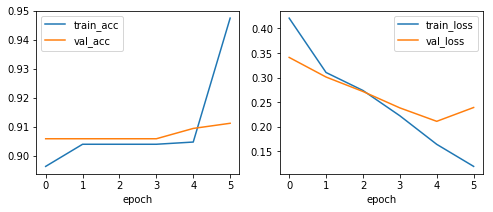

In [22]:
# get and plot training history
df=pd.DataFrame.from_dict(training.history)
df.columns=["val_loss", "val_acc", "train_loss","train_acc"]
df.index.name='epoch'
print(df)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3));
df[["train_acc", "val_acc"]].plot(ax=axes[0]);
df[["train_loss", "val_loss"]].plot(ax=axes[1]);
plt.show();

In [21]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


BEST_MODEL_FILEPATH="/Users/jason/Desktop/best_model"

earlyStopping=EarlyStopping(monitor='val_loss', patience=0, verbose=2, mode='min')
checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_acc', verbose=2, save_best_only=True, mode='max')

# compile model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

training=model.fit(X_train, y_train,batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=[earlyStopping, checkpoint],
          validation_data=[X_test, y_test],verbose=2)

Train on 1312 samples, validate on 563 samples
Epoch 1/15
 - 3s - loss: 0.4209 - acc: 0.8963 - val_loss: 0.3410 - val_acc: 0.9059

Epoch 00001: val_acc improved from -inf to 0.90586, saving model to /Users/jason/Desktop/best_model
Epoch 2/15
 - 2s - loss: 0.3103 - acc: 0.9040 - val_loss: 0.3010 - val_acc: 0.9059

Epoch 00002: val_acc did not improve from 0.90586
Epoch 3/15
 - 2s - loss: 0.2737 - acc: 0.9040 - val_loss: 0.2716 - val_acc: 0.9059

Epoch 00003: val_acc did not improve from 0.90586
Epoch 4/15
 - 2s - loss: 0.2223 - acc: 0.9040 - val_loss: 0.2383 - val_acc: 0.9059

Epoch 00004: val_acc did not improve from 0.90586
Epoch 5/15
 - 2s - loss: 0.1641 - acc: 0.9047 - val_loss: 0.2109 - val_acc: 0.9094

Epoch 00005: val_acc improved from 0.90586 to 0.90941, saving model to /Users/jason/Desktop/best_model
Epoch 6/15
 - 2s - loss: 0.1193 - acc: 0.9474 - val_loss: 0.2391 - val_acc: 0.9112

Epoch 00006: val_acc improved from 0.90941 to 0.91119, saving model to /Users/jason/Desktop/best

In [23]:

# load the model using the save file
model.load_weights("/Users/jason/Desktop/best_model")
# predict
pred=model.predict(X_test)
# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

lala=np.where(pred>0.9,1,0)
print(classification_report(y_test, lala, target_names=['0','1']))
pd.crosstab(pd.Series(y_test), pd.Series(lala[:,0]))

acc: 91.12%
              precision    recall  f1-score   support

           0       0.43      0.60      0.50        53
           1       0.96      0.92      0.94       510

   micro avg       0.89      0.89      0.89       563
   macro avg       0.69      0.76      0.72       563
weighted avg       0.91      0.89      0.89       563



col_0,0,1
row_0,,
0,32,21
1,43,467


0.87944876063633


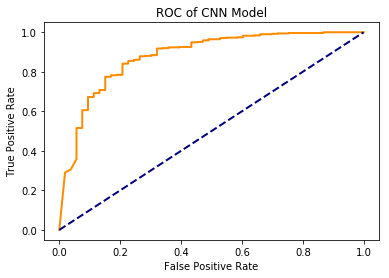

In [17]:
from sklearn.metrics import roc_curve, auc,precision_recall_curve
#calculate AUC
fpr, tpr, thresholds = roc_curve(y_test, pred,pos_label=1)
print(auc(fpr, tpr))
#plot ROC curve
plt.figure();
plt.plot(fpr, tpr, color='darkorange', lw=2);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC of CNN Model');
plt.show();

In [12]:
#To predict the sentiment for a certain wine bar 
pp=read_reviews(8,9)   
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(pp)
sequences = tokenizer.texts_to_sequences(pp)
padded_sequences2 = pad_sequences(sequences,  maxlen=MAX_DOC_LEN,padding='post', truncating='post')
predicted3=model.predict(padded_sequences2)

In [27]:
# topic extraction using CNN
data=pd.read_csv("/Users/jason/Documents/BIA study/Web Mining/Final Project/Data mining/Trainning_mutilabeled.csv",header=0)

text=list(data["Description"].copy())
text=pre_remove(text)
labels=data[["Food","Service","Atmosphere","Price"]].copy().values 

tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(text)
voc=tokenizer.word_index
sequences = tokenizer.texts_to_sequences(text)
padded_sequences = pad_sequences(sequences,maxlen=150,padding='post', truncating='post')

In [28]:
from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, \
Dropout, Activation, Input, Flatten, Concatenate
from keras.models import Model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
              
def cnn_model(FILTER_SIZES, \
              # filter sizes as a list
              MAX_NB_WORDS, \
              # total number of words
              MAX_DOC_LEN, \
              # max words in a doc
              EMBEDDING_DIM=100, \
              # word vector dimension
              NUM_FILTERS=64, \
              # number of filters for all size
              DROP_OUT=0.3, \
              # dropout rate
              NUM_OUTPUT_UNITS=1, \
              # number of output units
              NUM_DENSE_UNITS=100,\
              # number of units in dense layer
              PRETRAINED_WORD_VECTOR=None,\
              # Whether to use pretrained word vectors
              LAM=0.0):            
              # regularization coefficient
    
    main_input = Input(shape=(MAX_DOC_LEN,), \
                       dtype='int32', name='main_input')
    
    if PRETRAINED_WORD_VECTOR is not None:
        embed_1 = Embedding(input_dim=MAX_NB_WORDS+1, \
                        output_dim=EMBEDDING_DIM, \
                        input_length=MAX_DOC_LEN, \
                        # use pretrained word vectors
                        weights=[PRETRAINED_WORD_VECTOR],\
                        # word vectors can be further tuned
                        # set it to False if use static word vectors
                        trainable=True,\
                        name='embedding')(main_input)
    else:
        embed_1 = Embedding(input_dim=MAX_NB_WORDS+1, \
                        output_dim=EMBEDDING_DIM, \
                        input_length=MAX_DOC_LEN, \
                        name='embedding')(main_input)
    # add convolution-pooling-flat block
    conv_blocks = []
    for f in FILTER_SIZES:
        conv = Conv1D(filters=NUM_FILTERS, kernel_size=f, \
                      activation='relu', name='conv_'+str(f))(embed_1)
        conv = MaxPooling1D(MAX_DOC_LEN-f+1, name='max_'+str(f))(conv)
        conv = Flatten(name='flat_'+str(f))(conv)
        conv_blocks.append(conv)
    
    if len(conv_blocks)>1:
        z=Concatenate(name='concate')(conv_blocks)
    else:
        z=conv_blocks[0]
        
    drop=Dropout(rate=DROP_OUT, name='dropout')(z)

    dense = Dense(NUM_DENSE_UNITS, activation='relu',\
                    kernel_regularizer=l2(LAM),name='dense')(drop)
    preds = Dense(NUM_OUTPUT_UNITS, activation='sigmoid', name='output')(dense)
    model = Model(inputs=main_input, outputs=preds)
    
    model.compile(loss="binary_crossentropy", \
              optimizer="adam", metrics=["accuracy"]) 
    
    return model

In [29]:
EMBEDDING_DIM=100
FILTER_SIZES=[1,2,3,4]

# as the number of classes
num_filters=64
# set the dense units
dense_units_num= num_filters*len(FILTER_SIZES)

BTACH_SIZE = 64
NUM_EPOCHES = 20

X_train, X_test, Y_train, Y_test = train_test_split(padded_sequences, labels ,test_size=0.3, random_state=1)
model=cnn_model(FILTER_SIZES, MAX_NB_WORDS, MAX_DOC_LEN, NUM_FILTERS=num_filters,NUM_OUTPUT_UNITS=4, NUM_DENSE_UNITS=dense_units_num)


earlyStopping=EarlyStopping(monitor='val_loss', patience=0, verbose=2, mode='min')
checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_loss',verbose=2, save_best_only=True, mode='min')

training=model.fit(X_train, Y_train, batch_size=64, epochs=10,callbacks=[earlyStopping, checkpoint], validation_data=[X_test, Y_test], verbose=2)


Train on 969 samples, validate on 416 samples
Epoch 1/10
 - 3s - loss: 0.5837 - acc: 0.7366 - val_loss: 0.5724 - val_acc: 0.7506

Epoch 00001: val_loss improved from inf to 0.57243, saving model to /Users/jason/Desktop/best_model
Epoch 2/10
 - 2s - loss: 0.5257 - acc: 0.7693 - val_loss: 0.5309 - val_acc: 0.7506

Epoch 00002: val_loss improved from 0.57243 to 0.53087, saving model to /Users/jason/Desktop/best_model
Epoch 3/10
 - 2s - loss: 0.4886 - acc: 0.7696 - val_loss: 0.4881 - val_acc: 0.7710

Epoch 00003: val_loss improved from 0.53087 to 0.48805, saving model to /Users/jason/Desktop/best_model
Epoch 4/10
 - 2s - loss: 0.4238 - acc: 0.8331 - val_loss: 0.4085 - val_acc: 0.8450

Epoch 00004: val_loss improved from 0.48805 to 0.40846, saving model to /Users/jason/Desktop/best_model
Epoch 5/10
 - 2s - loss: 0.3481 - acc: 0.8689 - val_loss: 0.3618 - val_acc: 0.8624

Epoch 00005: val_loss improved from 0.40846 to 0.36180, saving model to /Users/jason/Desktop/best_model
Epoch 6/10
 - 2s -

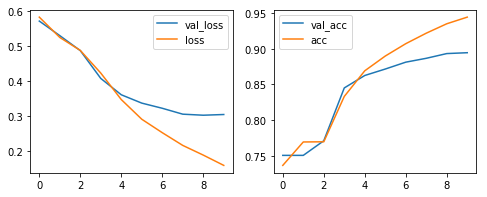

              precision    recall  f1-score   support

        Food       0.93      0.91      0.92       268
     Service       0.94      0.82      0.88       131
  Atmosphere       0.86      0.52      0.65        82
       Price       0.46      0.46      0.46        54

   micro avg       0.87      0.79      0.83       535
   macro avg       0.80      0.68      0.73       535
weighted avg       0.88      0.79      0.82       535
 samples avg       0.63      0.60      0.60       535

col_0    0    1
row_0          
0.0    130   24
1.0     18  244
col_0    0    1
row_0          
0.0    278   23
1.0      7  108
col_0    0   1
row_0         
0.0    327  39
1.0      7  43
col_0    0   1
row_0         
0.0    333  29
1.0     29  25


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [30]:
from sklearn.metrics import classification_report

#traning history
df=pd.DataFrame.from_dict(training.history)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3));
df[["val_loss", "loss"]].plot(ax=axes[0]);
df[["val_acc", "acc"]].plot(ax=axes[1]);
plt.show();
#predict and classify the output using different theshold
pred=model.predict(X_test)
pred[:,0]=np.where(pred[:,0]>0.5, 1, 0)
pred[:,1]=np.where(pred[:,1]>0.5, 1, 0)
pred[:,2]=np.where(pred[:,2]>0.28, 1, 0)
pred[:,3]=np.where(pred[:,3]>0.17, 1, 0)
#see the performance of this model
print(classification_report(Y_test, pred,target_names=['Food','Service','Atmosphere','Price']))
#confusion matrix
print(pd.crosstab(pred[:,0],Y_test[:,0]))
print(pd.crosstab(pred[:,1],Y_test[:,1]))
print(pd.crosstab(pred[:,2],Y_test[:,2]))
print(pd.crosstab(pred[:,3],Y_test[:,3]))


In [29]:
#To predict the topic for a certain wine bar
#let's take a 8th bar in our data as an example
pp=read_reviews(8,9)   
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(pp)
sequences = tokenizer.texts_to_sequences(pp)
padded_sequences3 = pad_sequences(sequences,  maxlen=MAX_DOC_LEN,padding='post', truncating='post')
predicted4=model.predict(padded_sequences3)

In [40]:
#Result interpret
#classify topic result classify
predicted4[:,0]=np.where(predicted4[:,0]>0.5, 1, 0)
predicted4[:,1]=np.where(predicted4[:,1]>0.5, 1, 0)
predicted4[:,2]=np.where(predicted4[:,2]>0.28, 1, 0)
predicted4[:,3]=np.where(predicted4[:,3]>0.17, 1, 0)
predictions2=pd.DataFrame(predicted4,columns=["Foodp","Servicep","Atmospherep","Pricep"])

#classify sentiment result 
predicted3=np.where(predicted3>0.9,1,0)
Food=pd.crosstab(predictions2["Foodp"],predicted3[:,0]).iloc[1,:]
Service=pd.crosstab(predictions2["Servicep"],predicted3[:,0]).iloc[1,:]
Atmosphere=pd.crosstab(predictions2["Atmospherep"],predicted3[:,0]).iloc[1,:]
Price=pd.crosstab(predictions2["Pricep"],predicted3[:,0]).iloc[1,:]
result=pd.DataFrame(dict(Food=Food, Service=Service,Atmosphere=Atmosphere,Price=Price))
print("total reviews:",len(pp))
print("Food:",result.iloc[0,0]/result.iloc[1,0])
print("Service:",result.iloc[0,1]/result.iloc[1,1])
print("Atmosphere:",result.iloc[0,2]/result.iloc[1,2])
print("Price:",result.iloc[0,3]/result.iloc[1,3])
result

total reviews: 311
Food: 0.16145833333333334
Service: 0.17142857142857143
Atmosphere: 0.06666666666666667
Price: 0.1590909090909091


,Food,Service,Atmosphere,Price
col_0,,,,
0,31,12,3,7
1,192,70,45,44
